In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import binned_statistic

%matplotlib inline

# Load Data

In [2]:
# df = pd.read_csv('../data/airborne_data.csv', parse_dates=['timestamp'], index_col='timestamp')
# df = pd.read_csv('../../data/airborne_data_20241015.csv', parse_dates=['timestamp'], index_col='timestamp')
df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')

/tmp/ipykernel_965437/1611110707.py:3: DtypeWarning: Columns (195) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/processed/complete_data.csv', parse_dates=['timestamp'], index_col='timestamp')


# Analysis

# Plot

In [3]:
campaign_dict = {"FIREX":"#b71528", "WECAN":"#dc8904", "DC3":"#6a9c30", "ARCTAS":"#1f487e","ATom":"#824a5a"}
color_dict = {"urban":"#246eb9","clean":"#4cb944","heavy_mixed":"#17C3B2","mixed":"#17C3B2","light_mixed":"#f5ee9e","fire":"#f06543",'none':'tab:brown',}
regime_names = {"urban":"Anthropogenic","clean":"Clean","heavy_mixed":"Mixed","light_mixed":"Light Mixed","fire":"Fire",'none':'tab:brown',}

/tmp/ipykernel_965437/3408972259.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_mixed['O3'] = fire_mixed['O3'] * 1e-3


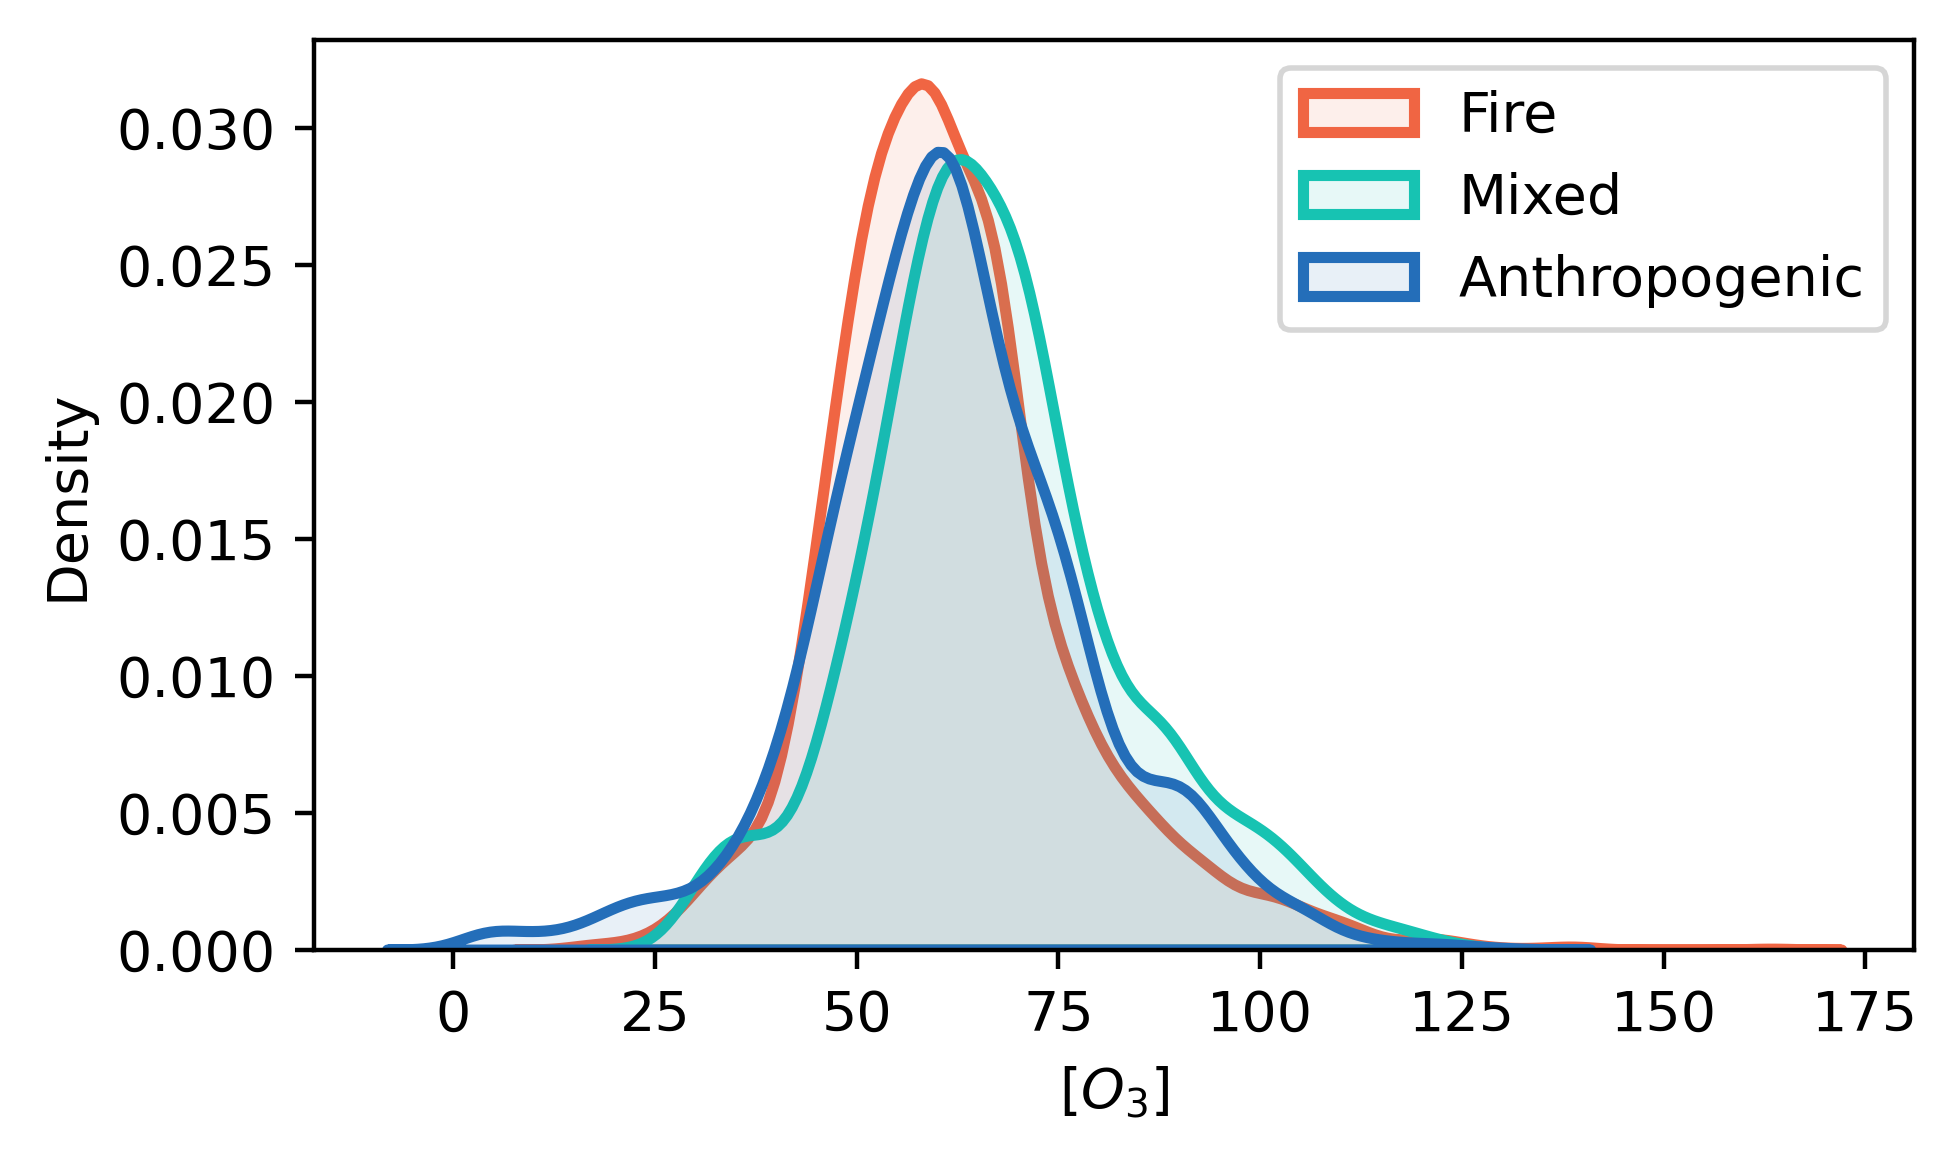

In [7]:
fig, ax = plt.subplots(figsize=(5,3), dpi=400)

tmp = df.copy(deep=True)
# Replace values in a specific column (e.g., 'Column1')

fire_mixed = tmp[(tmp['regime'] == 'fire')|(tmp['regime'] == 'heavy_mixed')|(tmp['regime'] == 'urban')]
# fire_mixed['regime'] = fire_mixed['regime'].replace(regime_names)
# fire_mixed = fire_mixed.replace('Heavy Mixed', 'Mixed')
# fire_mixed = fire_mixed.replace('heavy_mixed', 'mixed')
fire_mixed['O3'] = fire_mixed['O3'] * 1e-3

for regime in ['fire', 'heavy_mixed', 'urban']:
    sns.kdeplot(data=fire_mixed[fire_mixed['regime'] == regime], x='O3', ax=ax, fill=True, label=regime_names[regime], color=color_dict[regime], linewidth=2, alpha=0.1)



# snsFig = sns.kdeplot(data=fire_mixed, x='O3_delta', hue='regime', label=regime_names, palette=color_dict, ax=ax, fill=True, common_norm=False, linewidth=2, alpha=0.1)

ax.legend()

# ax.set_xlim(-1,2)
ax.set_xlabel(r'$[O_3]$')

plt.tight_layout()

### Figure 5a

/tmp/ipykernel_965437/3941098378.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_mixed['O3_delta'] = fire_mixed['O3_delta'] * 1e-3


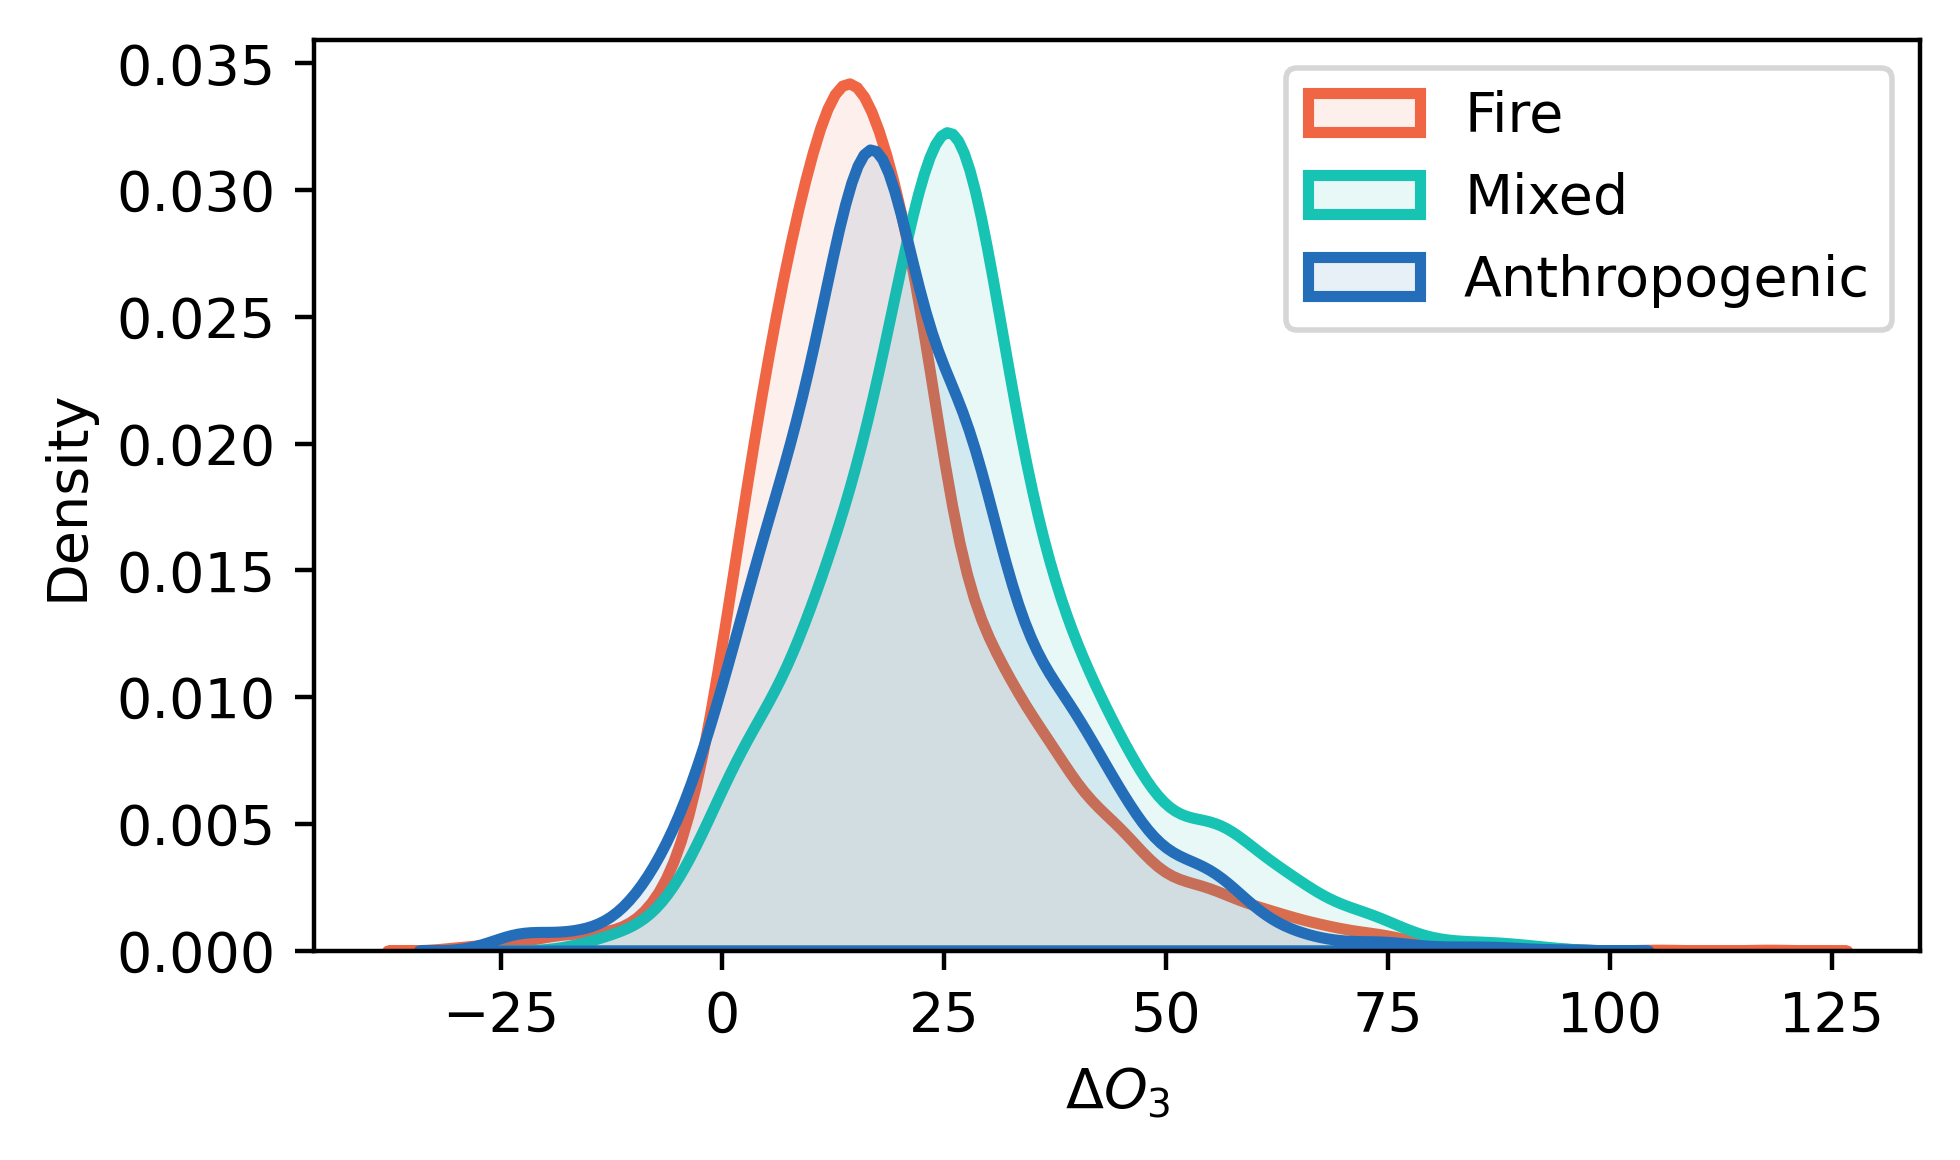

In [8]:
fig, ax = plt.subplots(figsize=(5,3), dpi=400)

tmp = df.copy(deep=True)
# Replace values in a specific column (e.g., 'Column1')

fire_mixed = tmp[(tmp['regime'] == 'fire')|(tmp['regime'] == 'heavy_mixed')|(tmp['regime'] == 'urban')]
# fire_mixed['regime'] = fire_mixed['regime'].replace(regime_names)
# fire_mixed = fire_mixed.replace('Heavy Mixed', 'Mixed')
# fire_mixed = fire_mixed.replace('heavy_mixed', 'mixed')
fire_mixed['O3_delta'] = fire_mixed['O3_delta'] * 1e-3

for regime in ['fire', 'heavy_mixed', 'urban']:
    sns.kdeplot(data=fire_mixed[fire_mixed['regime'] == regime], x='O3_delta', ax=ax, fill=True, label=regime_names[regime], color=color_dict[regime], linewidth=2, alpha=0.1)



# snsFig = sns.kdeplot(data=fire_mixed, x='O3_delta', hue='regime', label=regime_names, palette=color_dict, ax=ax, fill=True, common_norm=False, linewidth=2, alpha=0.1)

ax.legend()

# ax.set_xlim(-1,2)
ax.set_xlabel(r'$\Delta O_3$')

plt.tight_layout()
#save figure as pdf
plt.savefig("../../figures/fig_05a.png", bbox_inches='tight', dpi=300)

### Figure 5b

In [9]:
#load OHR data
firex_ohr_df = pd.read_csv('../../../data/ohr/FIREX/FIREX_TOGAmerge_ohr_total.csv', parse_dates=['timestamp'], index_col='timestamp')
wecan_ohr_df = pd.read_csv('../../../data/ohr/WECAN/WECAN_TOGAmerge_ohr_total.csv', parse_dates=['timestamp'], index_col='timestamp')
dc3_ohr_df = pd.read_csv('../../../data/ohr/DC3/DC3_60s_ohr_total.csv', parse_dates=['timestamp'], index_col='timestamp')
arctas_ohr_df = pd.read_csv('../../../data/ohr/ARCTAS/ARCTAS_TOGAmerge_ohr_total.csv', parse_dates=['timestamp'], index_col='timestamp')
atom_ohr_df = pd.read_csv('../../../data/ohr/ATOM/ATOM_TOGAmerge_ohr_total.csv', parse_dates=['timestamp'], index_col='timestamp')

In [10]:
full_ohr_df = pd.concat([firex_ohr_df, wecan_ohr_df, atom_ohr_df, arctas_ohr_df, dc3_ohr_df])

In [11]:
full_ohr_df = full_ohr_df[~full_ohr_df.index.duplicated(keep='first')]

In [12]:
ohr_merged_df = pd.merge(full_ohr_df, df, left_index=True, right_on='timestamp', how='inner', suffixes=('_ohr', ''))

In [13]:
fire = df[df['regime'] == 'fire']
mixed = df[df['regime'] == 'heavy_mixed']
urban = df[df['regime'] == 'urban']
clean = df[df['regime'] == 'clean']
near_field = df[df['age'] < 20]
far_field = df[df['age'] >= 20]

# Compute average values
avg_values = {
    'clean': (clean[['NOx', 'HNO3', 'PAN', 'HNO2', 'HNO4']].mean()*1e-3).to_dict(),
    'urban': (urban[['NOx', 'HNO3', 'PAN', 'HNO2', 'HNO4']].mean()*1e-3).to_dict(),
    'fire': (fire[['NOx', 'HNO3', 'PAN', 'HNO2', 'HNO4']].mean()*1e-3).to_dict(),
    'near_field': (near_field[['NOx', 'HNO3', 'PAN', 'HNO2', 'HNO4']].mean()*1e-3).to_dict(),
    'far_field': (far_field[['NOx', 'HNO3', 'PAN', 'HNO2', 'HNO4']].mean()*1e-3).to_dict(),
    'mixed': (mixed[['NOx', 'HNO3', 'PAN', 'HNO2', 'HNO4']].mean()*1e-3).to_dict(),
}

# Create a DataFrame for visualization
avg_df = pd.DataFrame(avg_values).T

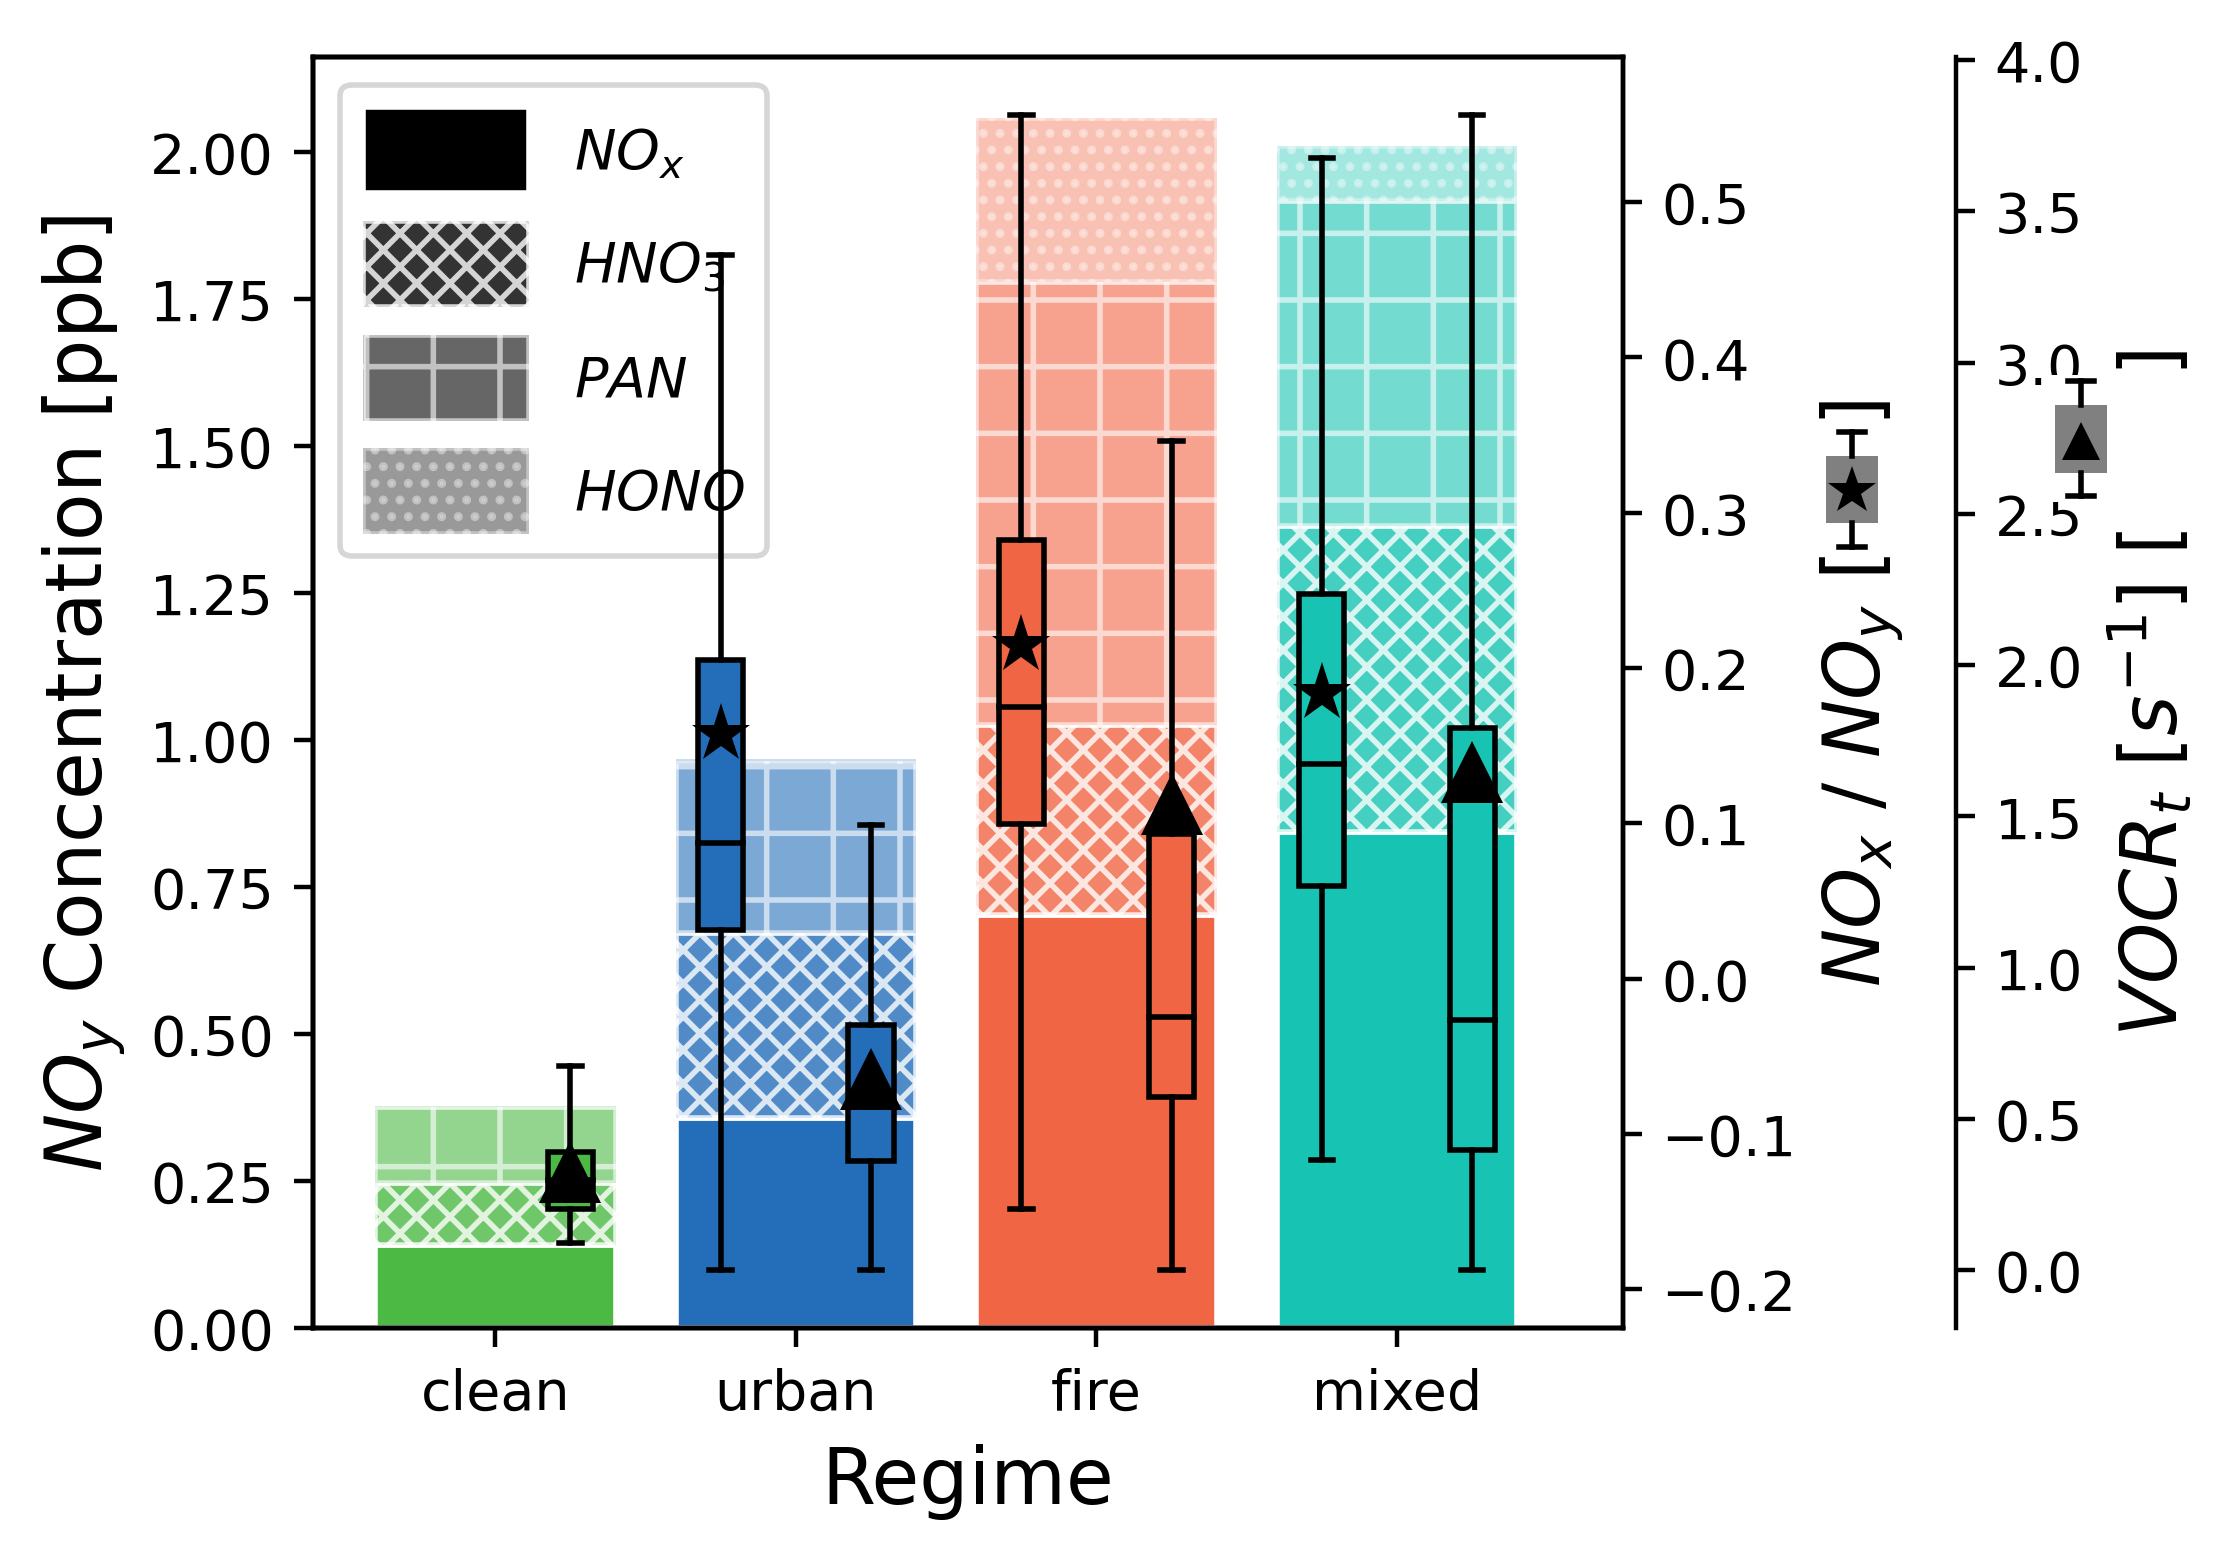

In [15]:
# Define colors for each regime (clean, urban, fire, mixed)
regime_colors = {
    # 'clean': 'grey',
    'clean': '#4cb944',
    'urban': '#246eb9', 
    'fire': '#f06543',  
    'mixed': '#17C3B2'   
}

species_labels = {
    'NOx': r'$NO_x$',
    'HNO3': r'$HNO_3$',
    'PAN': r'$PAN$', 
    'HNO2': r'$HONO$',  
}


# Define hatches for each species (NOx, HNO3, PAN, HNO2)
species_hatches = ['', 'xxxx', '+', '....']  # Different hatches for NOx, HNO3, PAN, HNO2

flierprops=dict(marker="_", markersize=2, markerfacecolor='black', linestyle='none')

# Define alpha values for each species
species_alpha = [1, 0.8, 0.6, 0.4]  # Transparency for NOx, HNO3, PAN, HNO2
# species_alpha.reverse()

# Plot the data
fig, ax = plt.subplots(figsize=(6, 4), dpi=400)

## second y axis
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

# Iterate over regimes and plot each with specific colors and apply hatches for species
for i, (regime, color) in enumerate(regime_colors.items()):
    bottom = None
    for j, (species, hatch, alpha) in enumerate(zip(avg_df.columns, species_hatches, species_alpha)):
        ax.bar(regime, avg_df.at[regime, species], color=color, hatch=hatch, edgecolor='white', alpha=alpha,
               label=species_labels[species] if i == 0 else "",  # Add label for the legend only once
               bottom=bottom)
        # Update the bottom to stack the bars
        bottom = avg_df.iloc[:, :j+1].loc[regime].sum() if bottom is None else bottom + avg_df[species].loc[regime]

    tmp = avg_df.loc[regime]
    if regime == 'mixed':
        full_tmp = ohr_merged_df[ohr_merged_df['regime'] == 'heavy_mixed']
    else:
        full_tmp = ohr_merged_df[ohr_merged_df['regime'] == regime]
    # full_tmp = full_tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=['theta'])
    # print(len(full_tmp))
    # ax4.scatter(regime, full_tmp['NOy'].mean()*1e-3, marker='D', color=color, s=50, label=r'Measured $NO_y$')

    if regime != 'clean':
        # NOx_NOy = full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])
        NOx_NOy = full_tmp['NOx']/(full_tmp['NOy'])
        ax2.boxplot(NOx_NOy.dropna(), positions=[i-0.25], widths=0.15, showfliers=False, showmeans=True, meanprops=dict(marker='*', markeredgecolor='None', markerfacecolor='k', markersize=11), patch_artist=True, boxprops=dict(facecolor=color, color='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))
        # ax2.scatter(regime, np.nanmean(full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])), marker='*', s=100, color='k', label='NOx/NOy')
        # ax2.errorbar(regime, np.nanmean(full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])), 
        #             yerr=np.nanstd(full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])), 
        #             fmt='none', ecolor='k', capsize=2, linewidth=1)
        # ax2.scatter(regime, np.nanmean(full_tmp['CH2O']), marker='*', s=100, color='k')
        # ax2.errorbar(regime, np.nanmean(full_tmp['CH2O']), 
        #             yerr=np.nanstd(full_tmp['CH2O']), 
        #             fmt='none', ecolor='k', capsize=2, linewidth=1)
        # ax2.violinplot(quantity.dropna(), positions=[i], widths=0.5, showmedians=True, showextrema=False, showmeans=False, points=100, bw_method=0.5)
        # ax2.scatter(regime, np.nanmean(quantity), marker='*', s=100, color='k')
        # ax2.errorbar(regime, np.nanmean(quantity), 
        #             yerr=np.nanstd(quantity), 
        #             fmt='none', ecolor='k', capsize=2, linewidth=1)
    quantity = full_tmp['CO_ohr']+full_tmp['CH4_ohr']+full_tmp['Ethene_ohr']+full_tmp['CH2O_ohr']+full_tmp['Propane_ohr']+full_tmp['Isoprene_ohr']+full_tmp['Furan_ohr']+full_tmp['Benzene_ohr']+full_tmp['Toluene_ohr']
    ax3.boxplot(quantity.dropna(), positions=[i+0.25], widths=0.15, showfliers=False, showmeans=True, meanprops=dict(marker='^', markeredgecolor='None', markerfacecolor='k', markersize=11), patch_artist=True, boxprops=dict(facecolor=color, color='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))

# Create custom legend patches with grey color and respective hatches
legend_patches = [Patch(facecolor='black', edgecolor='white', hatch=hatch, alpha=alpha, label=species_labels[species]) 
                  for species, hatch, alpha in zip(avg_df.columns, species_hatches, species_alpha)]

legend = ax.legend(handles=legend_patches, handleheight=2, handlelength=3, loc='upper left',)

# Simulate some data for the example
# data = np.random.normal(1.0, 2.0, 100)  # Random data for the box plot
data = np.random.normal(10, 2, 100)  # Normal data centered around 10 with std deviation of 2
data = np.clip(data, 7.5, 12.5)      # Clip the data to have short whiskers (limits the min/max)

# Add another small box plot inside the empty brackets in the y_label
# Position the inset_axes to be in a specific location on the ax3 plot
small_box_ohr = ax3.inset_axes([1.325, 0.65, 0.05, 0.1], )  # Adjust position and size
small_box_ohr.boxplot(data, vert=True, widths=0.8, showfliers=False, showmeans=True, meanprops=dict(marker='^', markeredgecolor='None', markerfacecolor='k', markersize=7), patch_artist=True, boxprops=dict(facecolor='grey', color='None'), medianprops=dict(color='None'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))  # Vertical box plot
small_box_ohr.set_xticks([])  # Remove x-ticks for the small box plot
small_box_ohr.set_yticks([])  # Remove y-ticks
# Remove the inset axes outline
for spine in small_box_ohr.spines.values():
    spine.set_visible(False)

# Position the inset_axes to be in a specific location on the ax3 plot
small_box_noxnoy = ax2.inset_axes([1.15, 0.61, 0.05, 0.1], )  # Adjust position and size
small_box_noxnoy.boxplot(data, vert=True, widths=0.8, showfliers=False, showmeans=True, meanprops=dict(marker='*', markeredgecolor='None', markerfacecolor='k', markersize=9), patch_artist=True, boxprops=dict(facecolor='grey', color='None'), medianprops=dict(color='None'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))  # Vertical box plot
small_box_noxnoy.set_xticks([])  # Remove x-ticks for the small box plot
small_box_noxnoy.set_yticks([])  # Remove y-ticks
# Remove the inset axes outline
for spine in small_box_noxnoy.spines.values():
    spine.set_visible(False)

# Ensure both axes share the same y-limits
# ax.set_ylim(ax4.get_ylim())
ax4.set_axis_off()
# Get the handles and labels from the axis
handles, labels = ax4.get_legend_handles_labels()
# legend_handle = handles[0]
# legend_handle.set_color('black')  # Change patch color
# legend_handle.set_edgecolor('black')  # Optionally, set edge color

# Customize the plot
# ax.set_title('Average Values of NOx, HNO3, PAN, HNO2 across regimes')
ax.set_ylabel(r'$NO_y$ Concentration [ppb]', fontsize=14)
ax.set_xlabel('Regime', fontsize=14)
# ax4.legend(handles=[legend_handle], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.57, 1),)
ax2.set_ylabel(r'$NO_x$ / $NO_y $ [     ]', fontsize=14,)
# ax2.set_ylim(-0.05, 0.9)
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel(r'$VOCR_{t}$ [$s^{-1}$] [      ]', fontsize=14,)
ax3.set_xticks([]) 
ax.set_xticks(['clean', 'urban', 'fire', 'mixed']) 
ax.set_xticklabels(['clean', 'urban', 'fire', 'mixed']) 

plt.tight_layout()
#save figure as pdf
plt.savefig("../../figures/fig_05b.png", bbox_inches='tight', dpi=300)
plt.show()


/tmp/ipykernel_965437/1860923060.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_mixed['O3_delta'] = fire_mixed['O3_delta'] * 1e-3


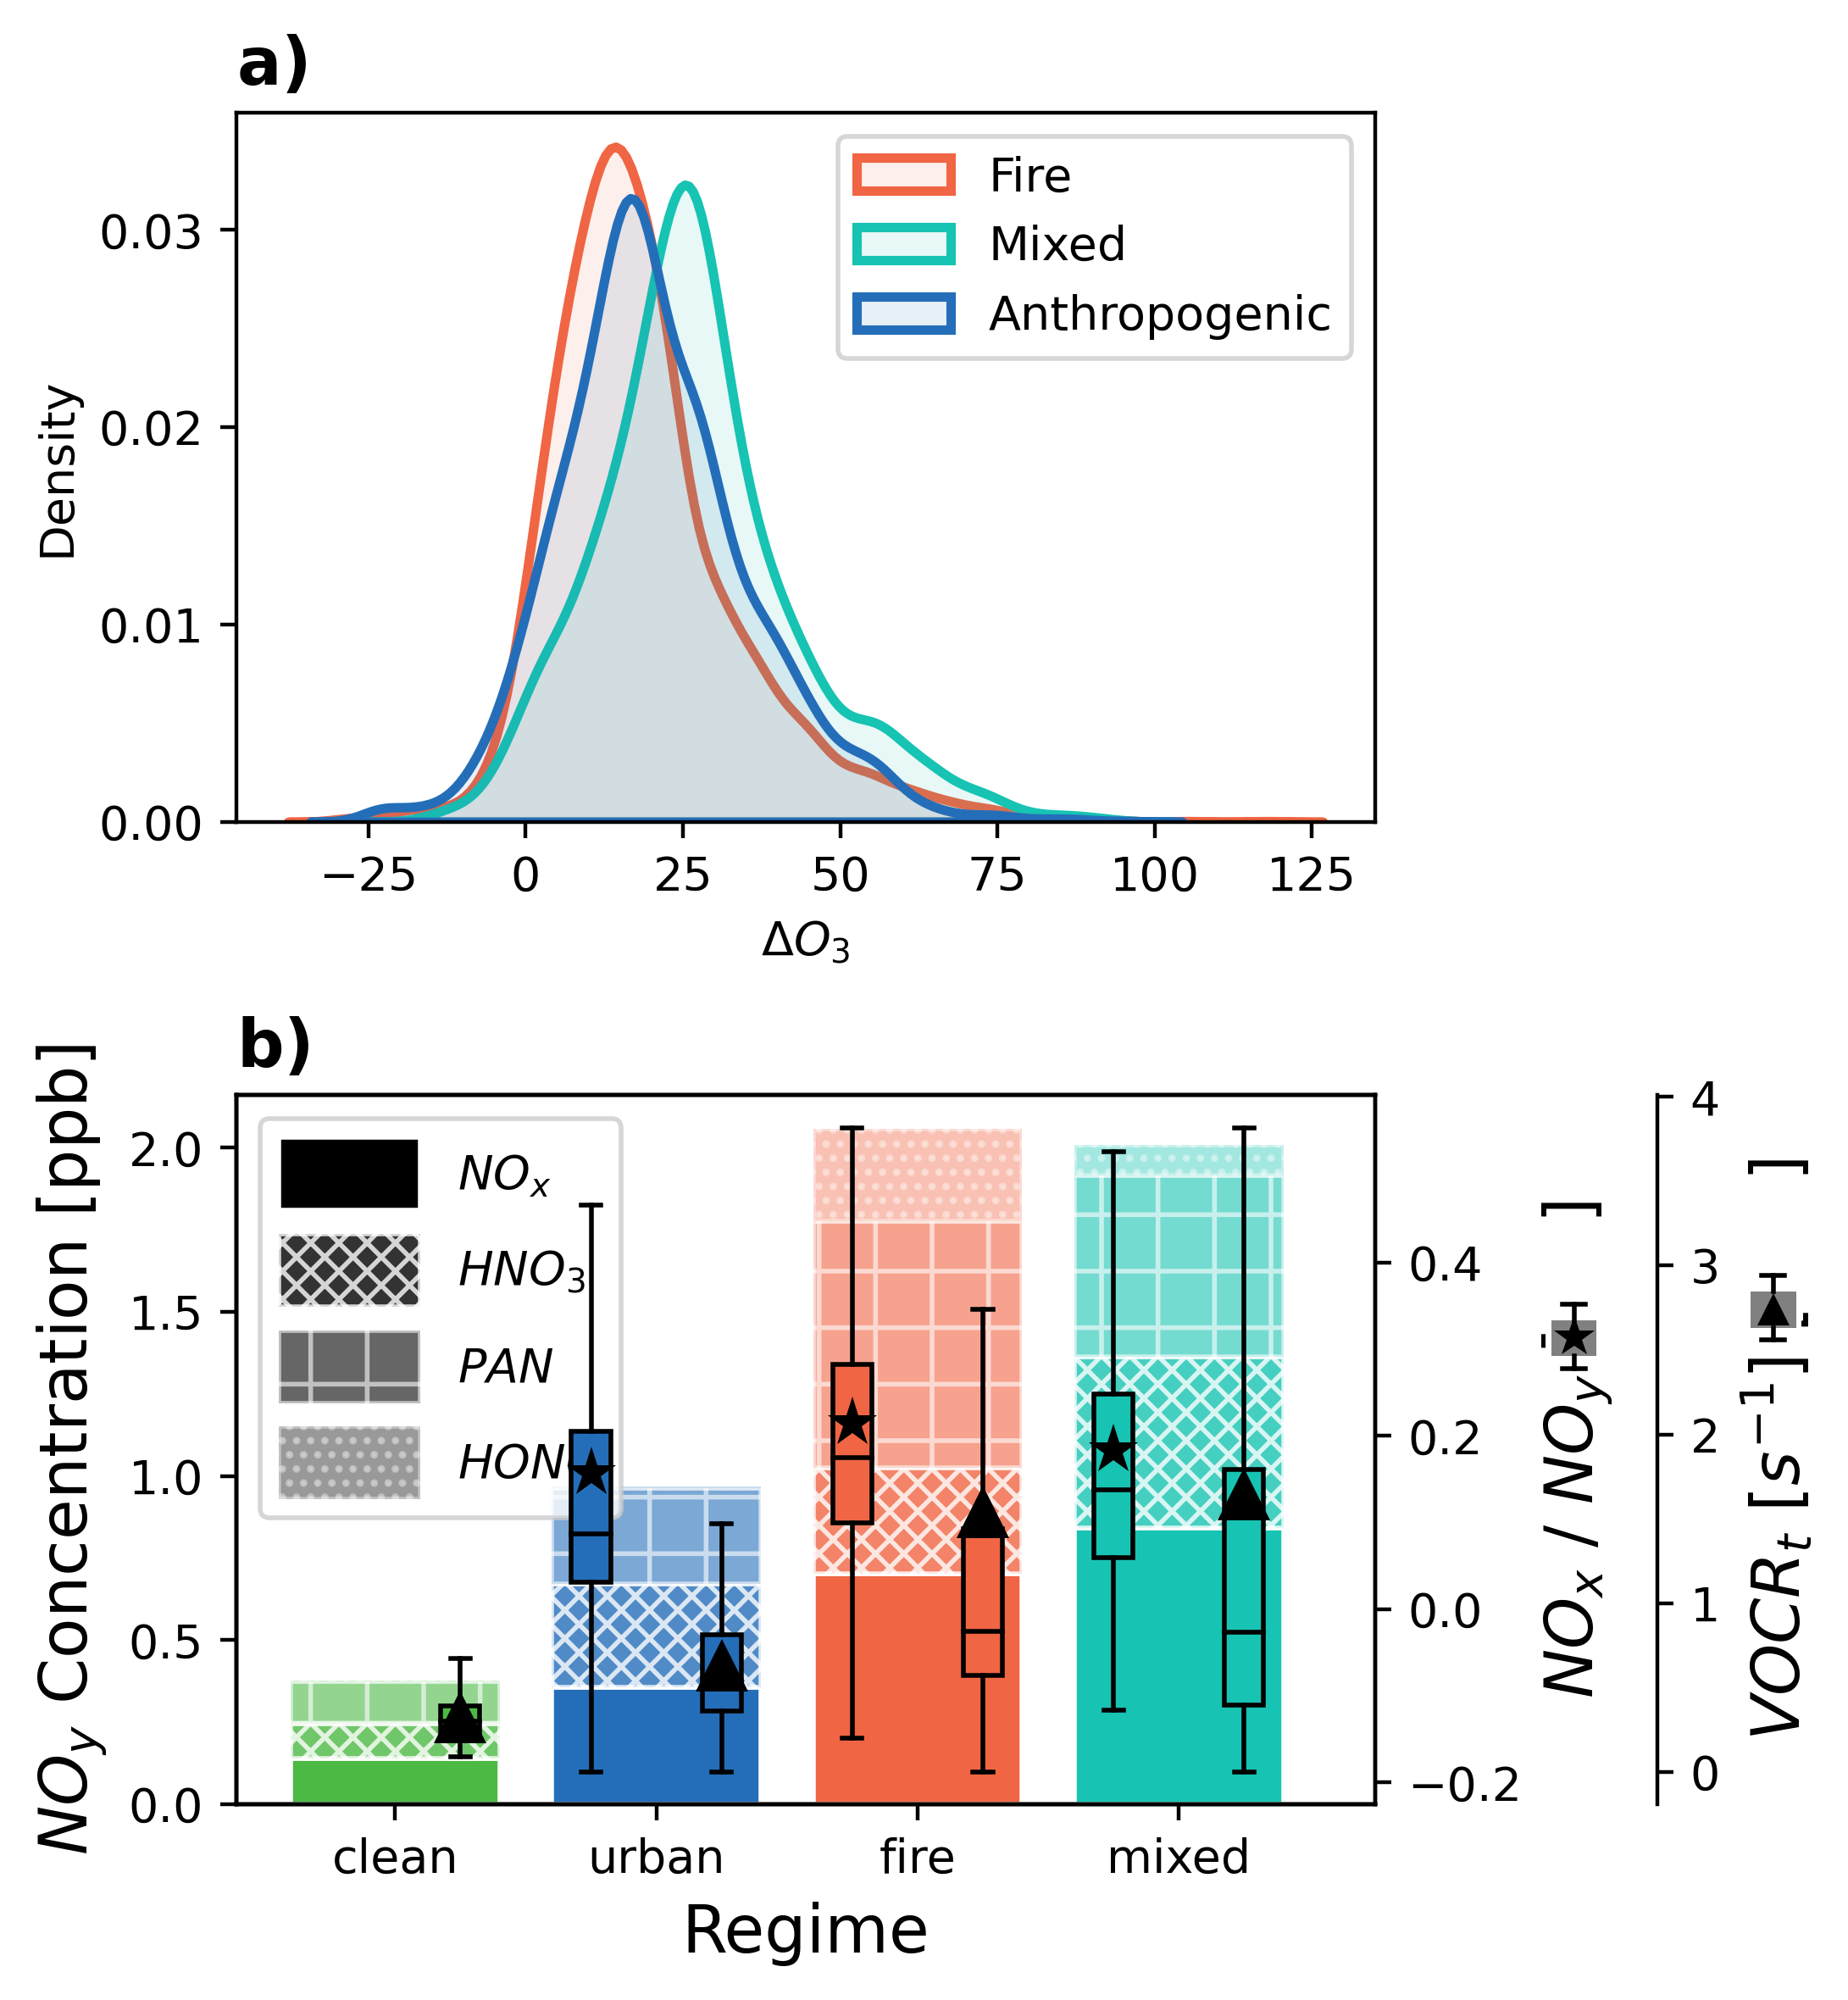

### Combined Figure 5

/tmp/ipykernel_965437/1756232903.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_mixed['O3_delta'] = fire_mixed['O3_delta'] * 1e-3


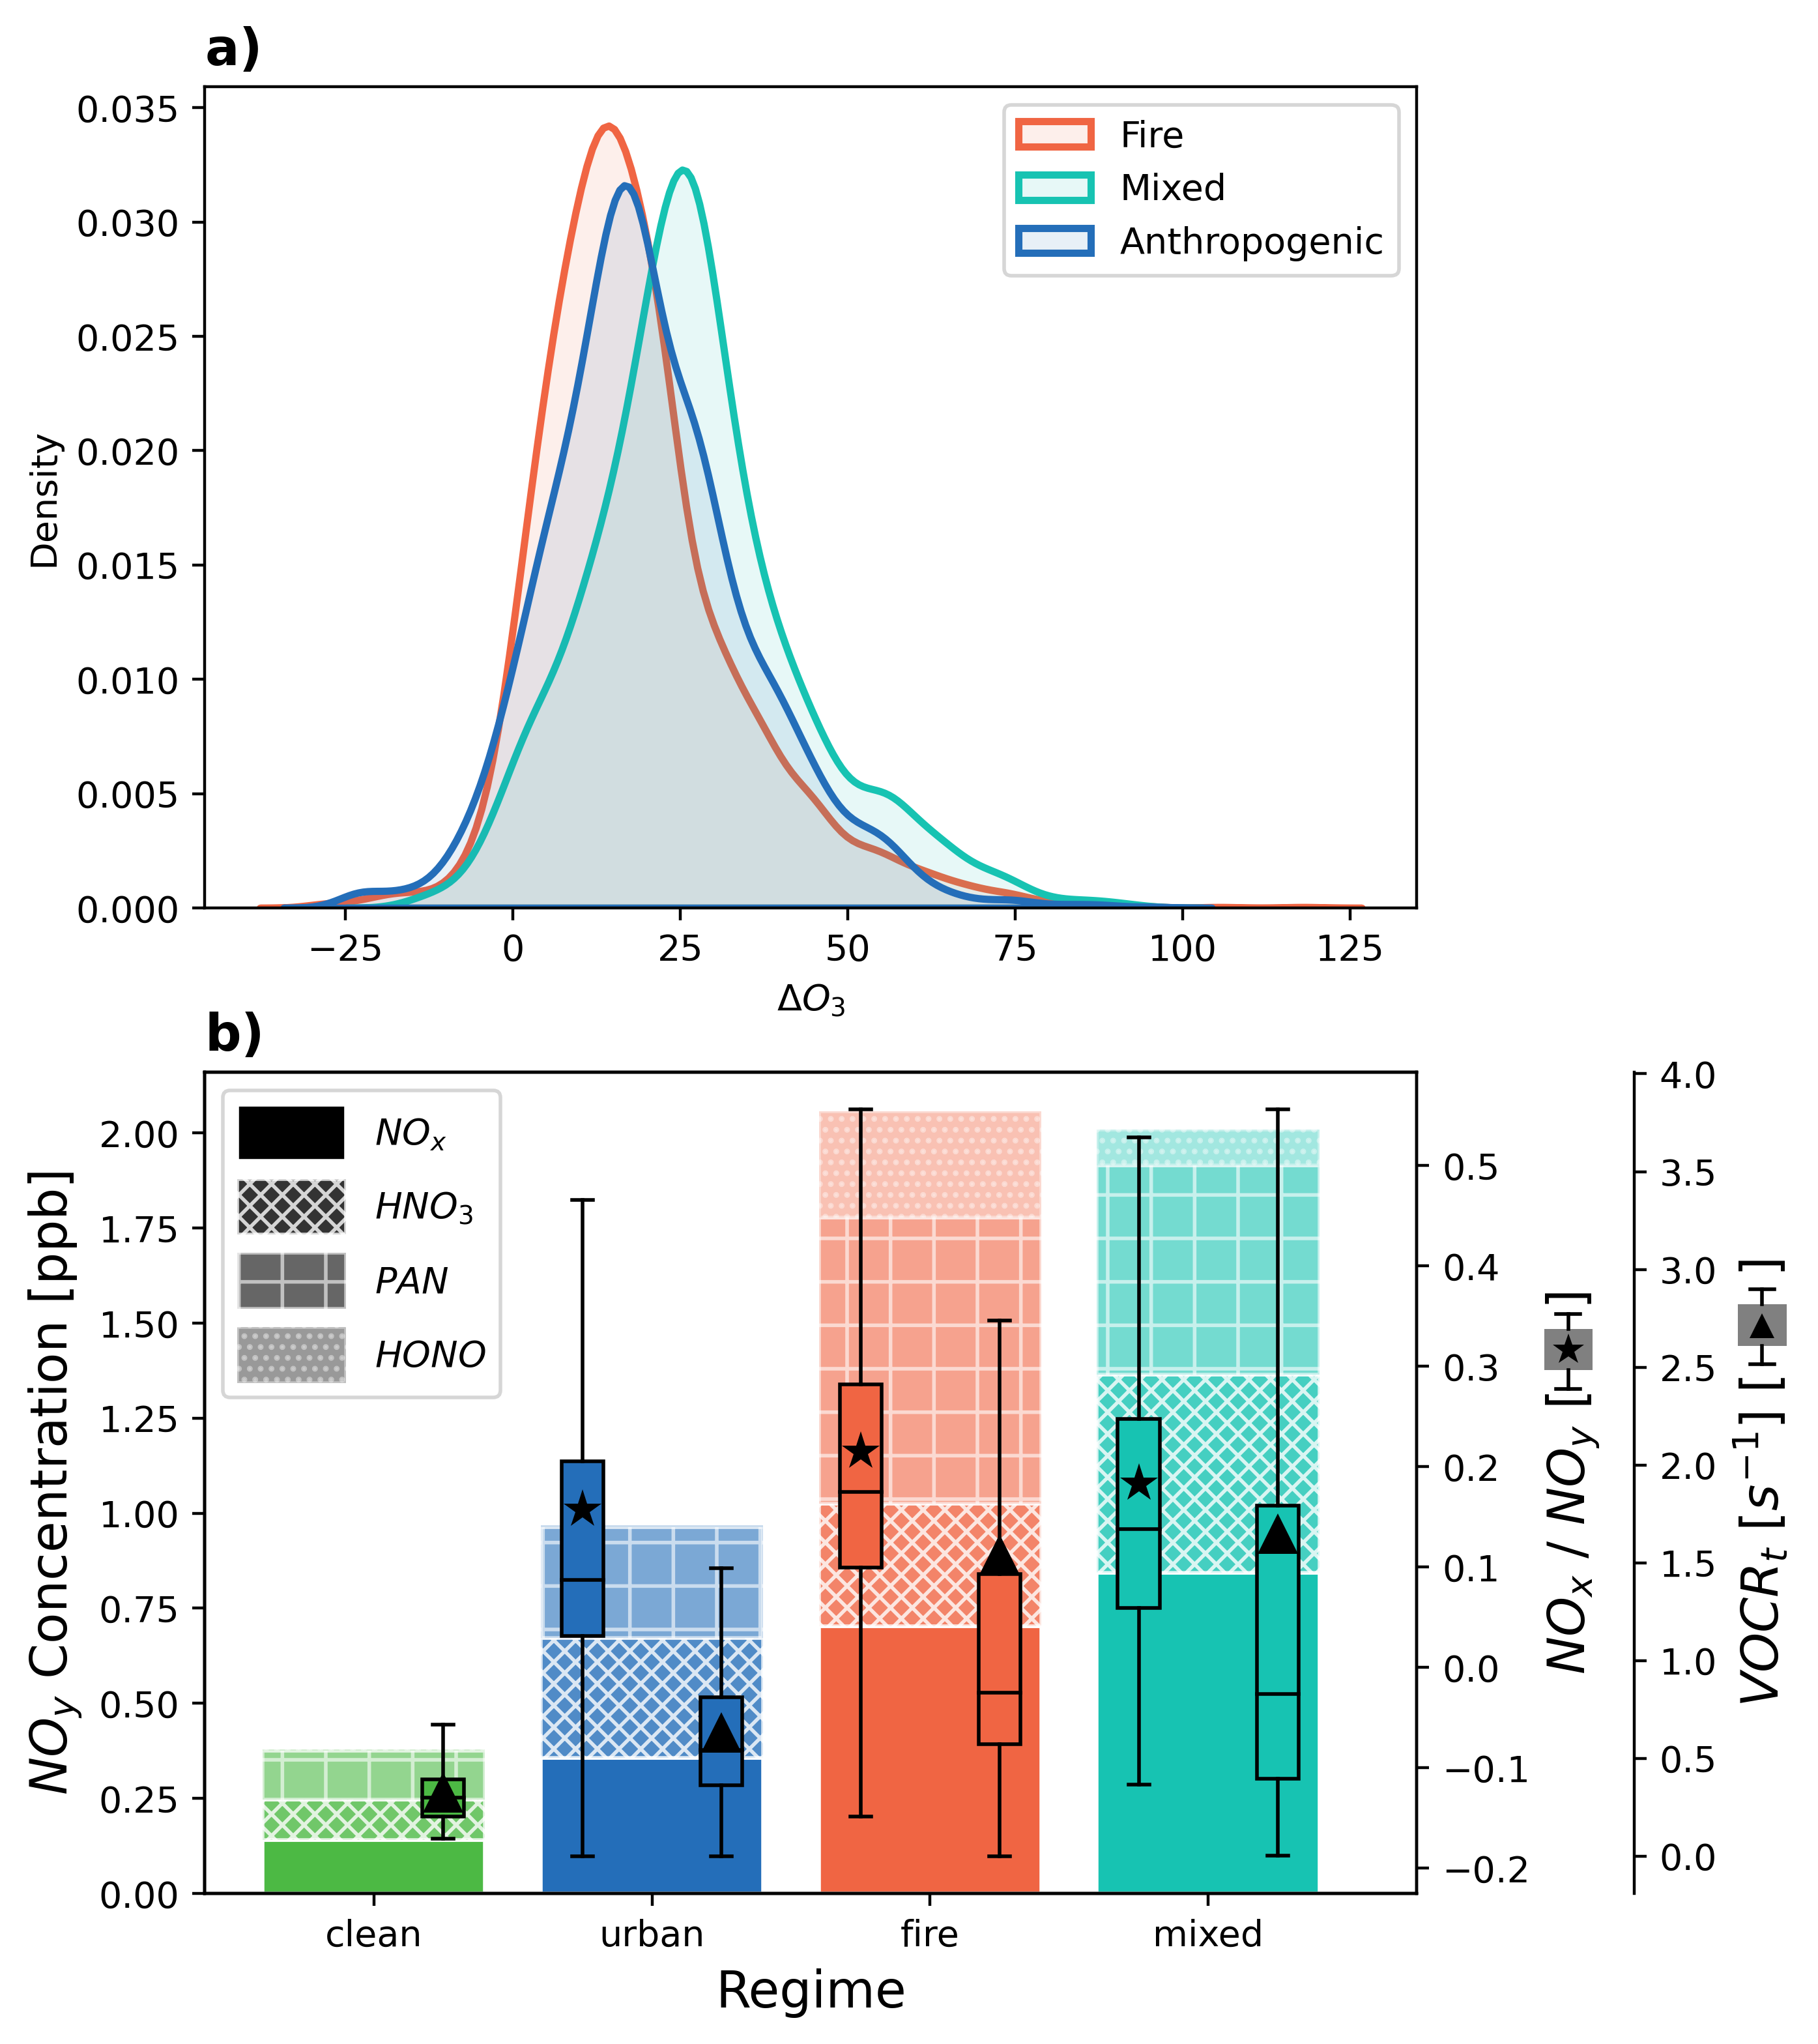

In [50]:
# combine figure 5a and 5b into a plot with two subplots

fig, axs = plt.subplots(2,1, figsize=(6,9), dpi=400)

### 5a

tmp = df.copy(deep=True)
# Replace values in a specific column (e.g., 'Column1')

fire_mixed = tmp[(tmp['regime'] == 'fire')|(tmp['regime'] == 'heavy_mixed')|(tmp['regime'] == 'urban')]
# fire_mixed['regime'] = fire_mixed['regime'].replace(regime_names)
# fire_mixed = fire_mixed.replace('Heavy Mixed', 'Mixed')
# fire_mixed = fire_mixed.replace('heavy_mixed', 'mixed')
fire_mixed['O3_delta'] = fire_mixed['O3_delta'] * 1e-3

for regime in ['fire', 'heavy_mixed', 'urban']:
    sns.kdeplot(data=fire_mixed[fire_mixed['regime'] == regime], x='O3_delta', ax=axs[0], fill=True, label=regime_names[regime], color=color_dict[regime], linewidth=2, alpha=0.1)



# snsFig = sns.kdeplot(data=fire_mixed, x='O3_delta', hue='regime', label=regime_names, palette=color_dict, ax=ax, fill=True, common_norm=False, linewidth=2, alpha=0.1)

axs[0].legend()

# ax.set_xlim(-1,2)
axs[0].set_xlabel(r'$\Delta O_3$')

axs[0].set_title(r'$\bf{a)}$', fontsize=14, loc='left')

### 5b

# Get the original position of axs[1]
pos1 = axs[1].get_position()

# Shrink the width (reduce x1)
# axs[1].set_position([pos1.x0, pos1.y0, pos1.width * 0.5, pos1.height])

ax = axs[1]

# second y axis
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

# Iterate over regimes and plot each with specific colors and apply hatches for species
for i, (regime, color) in enumerate(regime_colors.items()):
    bottom = None
    for j, (species, hatch, alpha) in enumerate(zip(avg_df.columns, species_hatches, species_alpha)):
        ax.bar(regime, avg_df.at[regime, species], color=color, hatch=hatch, edgecolor='white', alpha=alpha,
               label=species_labels[species] if i == 0 else "",  # Add label for the legend only once
               bottom=bottom)
        # Update the bottom to stack the bars
        bottom = avg_df.iloc[:, :j+1].loc[regime].sum() if bottom is None else bottom + avg_df[species].loc[regime]

    tmp = avg_df.loc[regime]
    if regime == 'mixed':
        full_tmp = ohr_merged_df[ohr_merged_df['regime'] == 'heavy_mixed']
    else:
        full_tmp = ohr_merged_df[ohr_merged_df['regime'] == regime]
    # full_tmp = full_tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=['theta'])
    # print(len(full_tmp))
    # ax4.scatter(regime, full_tmp['NOy'].mean()*1e-3, marker='D', color=color, s=50, label=r'Measured $NO_y$')

    if regime != 'clean':
        # NOx_NOy = full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])
        NOx_NOy = full_tmp['NOx']/(full_tmp['NOy'])
        ax2.boxplot(NOx_NOy.dropna(), positions=[i-0.25], widths=0.15, showfliers=False, showmeans=True, meanprops=dict(marker='*', markeredgecolor='None', markerfacecolor='k', markersize=11), patch_artist=True, boxprops=dict(facecolor=color, color='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))
        # ax2.scatter(regime, np.nanmean(full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])), marker='*', s=100, color='k', label='NOx/NOy')
        # ax2.errorbar(regime, np.nanmean(full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])), 
        #             yerr=np.nanstd(full_tmp['NOx']/(full_tmp['NOx']+full_tmp['HNO2']+full_tmp['HNO3']+full_tmp['PAN'])), 
        #             fmt='none', ecolor='k', capsize=2, linewidth=1)
        # ax2.scatter(regime, np.nanmean(full_tmp['CH2O']), marker='*', s=100, color='k')
        # ax2.errorbar(regime, np.nanmean(full_tmp['CH2O']), 
        #             yerr=np.nanstd(full_tmp['CH2O']), 
        #             fmt='none', ecolor='k', capsize=2, linewidth=1)
        # ax2.violinplot(quantity.dropna(), positions=[i], widths=0.5, showmedians=True, showextrema=False, showmeans=False, points=100, bw_method=0.5)
        # ax2.scatter(regime, np.nanmean(quantity), marker='*', s=100, color='k')
        # ax2.errorbar(regime, np.nanmean(quantity), 
        #             yerr=np.nanstd(quantity), 
        #             fmt='none', ecolor='k', capsize=2, linewidth=1)
    quantity = full_tmp['CO_ohr']+full_tmp['CH4_ohr']+full_tmp['Ethene_ohr']+full_tmp['CH2O_ohr']+full_tmp['Propane_ohr']+full_tmp['Isoprene_ohr']+full_tmp['Furan_ohr']+full_tmp['Benzene_ohr']+full_tmp['Toluene_ohr']
    ax3.boxplot(quantity.dropna(), positions=[i+0.25], widths=0.15, showfliers=False, showmeans=True, meanprops=dict(marker='^', markeredgecolor='None', markerfacecolor='k', markersize=11), patch_artist=True, boxprops=dict(facecolor=color, color='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))

# Create custom legend patches with grey color and respective hatches
legend_patches = [Patch(facecolor='black', edgecolor='white', hatch=hatch, alpha=alpha, label=species_labels[species]) 
                  for species, hatch, alpha in zip(avg_df.columns, species_hatches, species_alpha)]

legend = ax.legend(handles=legend_patches, handleheight=2, handlelength=3, loc='upper left',)

# Simulate some data for the example
# data = np.random.normal(1.0, 2.0, 100)  # Random data for the box plot
data = np.random.normal(10, 2, 100)  # Normal data centered around 10 with std deviation of 2
data = np.clip(data, 7.5, 12.5)      # Clip the data to have short whiskers (limits the min/max)

# Add another small box plot inside the empty brackets in the y_label
# Position the inset_axes to be in a specific location on the ax3 plot
small_box_ohr = ax3.inset_axes([1.26, 0.64, 0.05, 0.1], )  # Adjust position and size
small_box_ohr.boxplot(data, vert=True, widths=0.8, showfliers=False, showmeans=True, meanprops=dict(marker='^', markeredgecolor='None', markerfacecolor='k', markersize=7), patch_artist=True, boxprops=dict(facecolor='grey', color='None'), medianprops=dict(color='None'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))  # Vertical box plot
small_box_ohr.set_xticks([])  # Remove x-ticks for the small box plot
small_box_ohr.set_yticks([])  # Remove y-ticks
# Remove the inset axes outline
for spine in small_box_ohr.spines.values():
    spine.set_visible(False)

# Position the inset_axes to be in a specific location on the ax3 plot
small_box_noxnoy = ax2.inset_axes([1.10, 0.61, 0.05, 0.1], )  # Adjust position and size
small_box_noxnoy.boxplot(data, vert=True, widths=0.8, showfliers=False, showmeans=True, meanprops=dict(marker='*', markeredgecolor='None', markerfacecolor='k', markersize=9), patch_artist=True, boxprops=dict(facecolor='grey', color='None'), medianprops=dict(color='None'), whiskerprops=dict(color='black',), flierprops=flierprops, capprops=dict(color='black'))  # Vertical box plot
small_box_noxnoy.set_xticks([])  # Remove x-ticks for the small box plot
small_box_noxnoy.set_yticks([])  # Remove y-ticks
# Remove the inset axes outline
for spine in small_box_noxnoy.spines.values():
    spine.set_visible(False)

# Ensure both axes share the same y-limits
# ax.set_ylim(ax4.get_ylim())
ax4.set_axis_off()
# Get the handles and labels from the axis
handles, labels = ax4.get_legend_handles_labels()
# legend_handle = handles[0]
# legend_handle.set_color('black')  # Change patch color
# legend_handle.set_edgecolor('black')  # Optionally, set edge color

# Customize the plot
# ax.set_title('Average Values of NOx, HNO3, PAN, HNO2 across regimes')
ax.set_ylabel(r'$NO_y$ Concentration [ppb]', fontsize=14)
ax.set_xlabel('Regime', fontsize=14)
# ax4.legend(handles=[legend_handle], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.57, 1),)
ax2.set_ylabel(r'$NO_x$ / $NO_y $ [     ]', fontsize=14,)
# ax2.set_ylim(-0.05, 0.9)
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel(r'$VOCR_{t}$ [$s^{-1}$] [      ]', fontsize=14,)
ax3.set_xticks([]) 
ax.set_xticks(['clean', 'urban', 'fire', 'mixed']) 
ax.set_xticklabels(['clean', 'urban', 'fire', 'mixed']) 

axs[1].set_title(r'$\bf{b)}$', fontsize=14, loc='left')

#save figure as pdf
plt.savefig("../../figures/fig_05.pdf", bbox_inches='tight', dpi=300)

# plt.tight_layout()

### Figure S9

/home/jpalmo/.conda/envs/o3fire/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


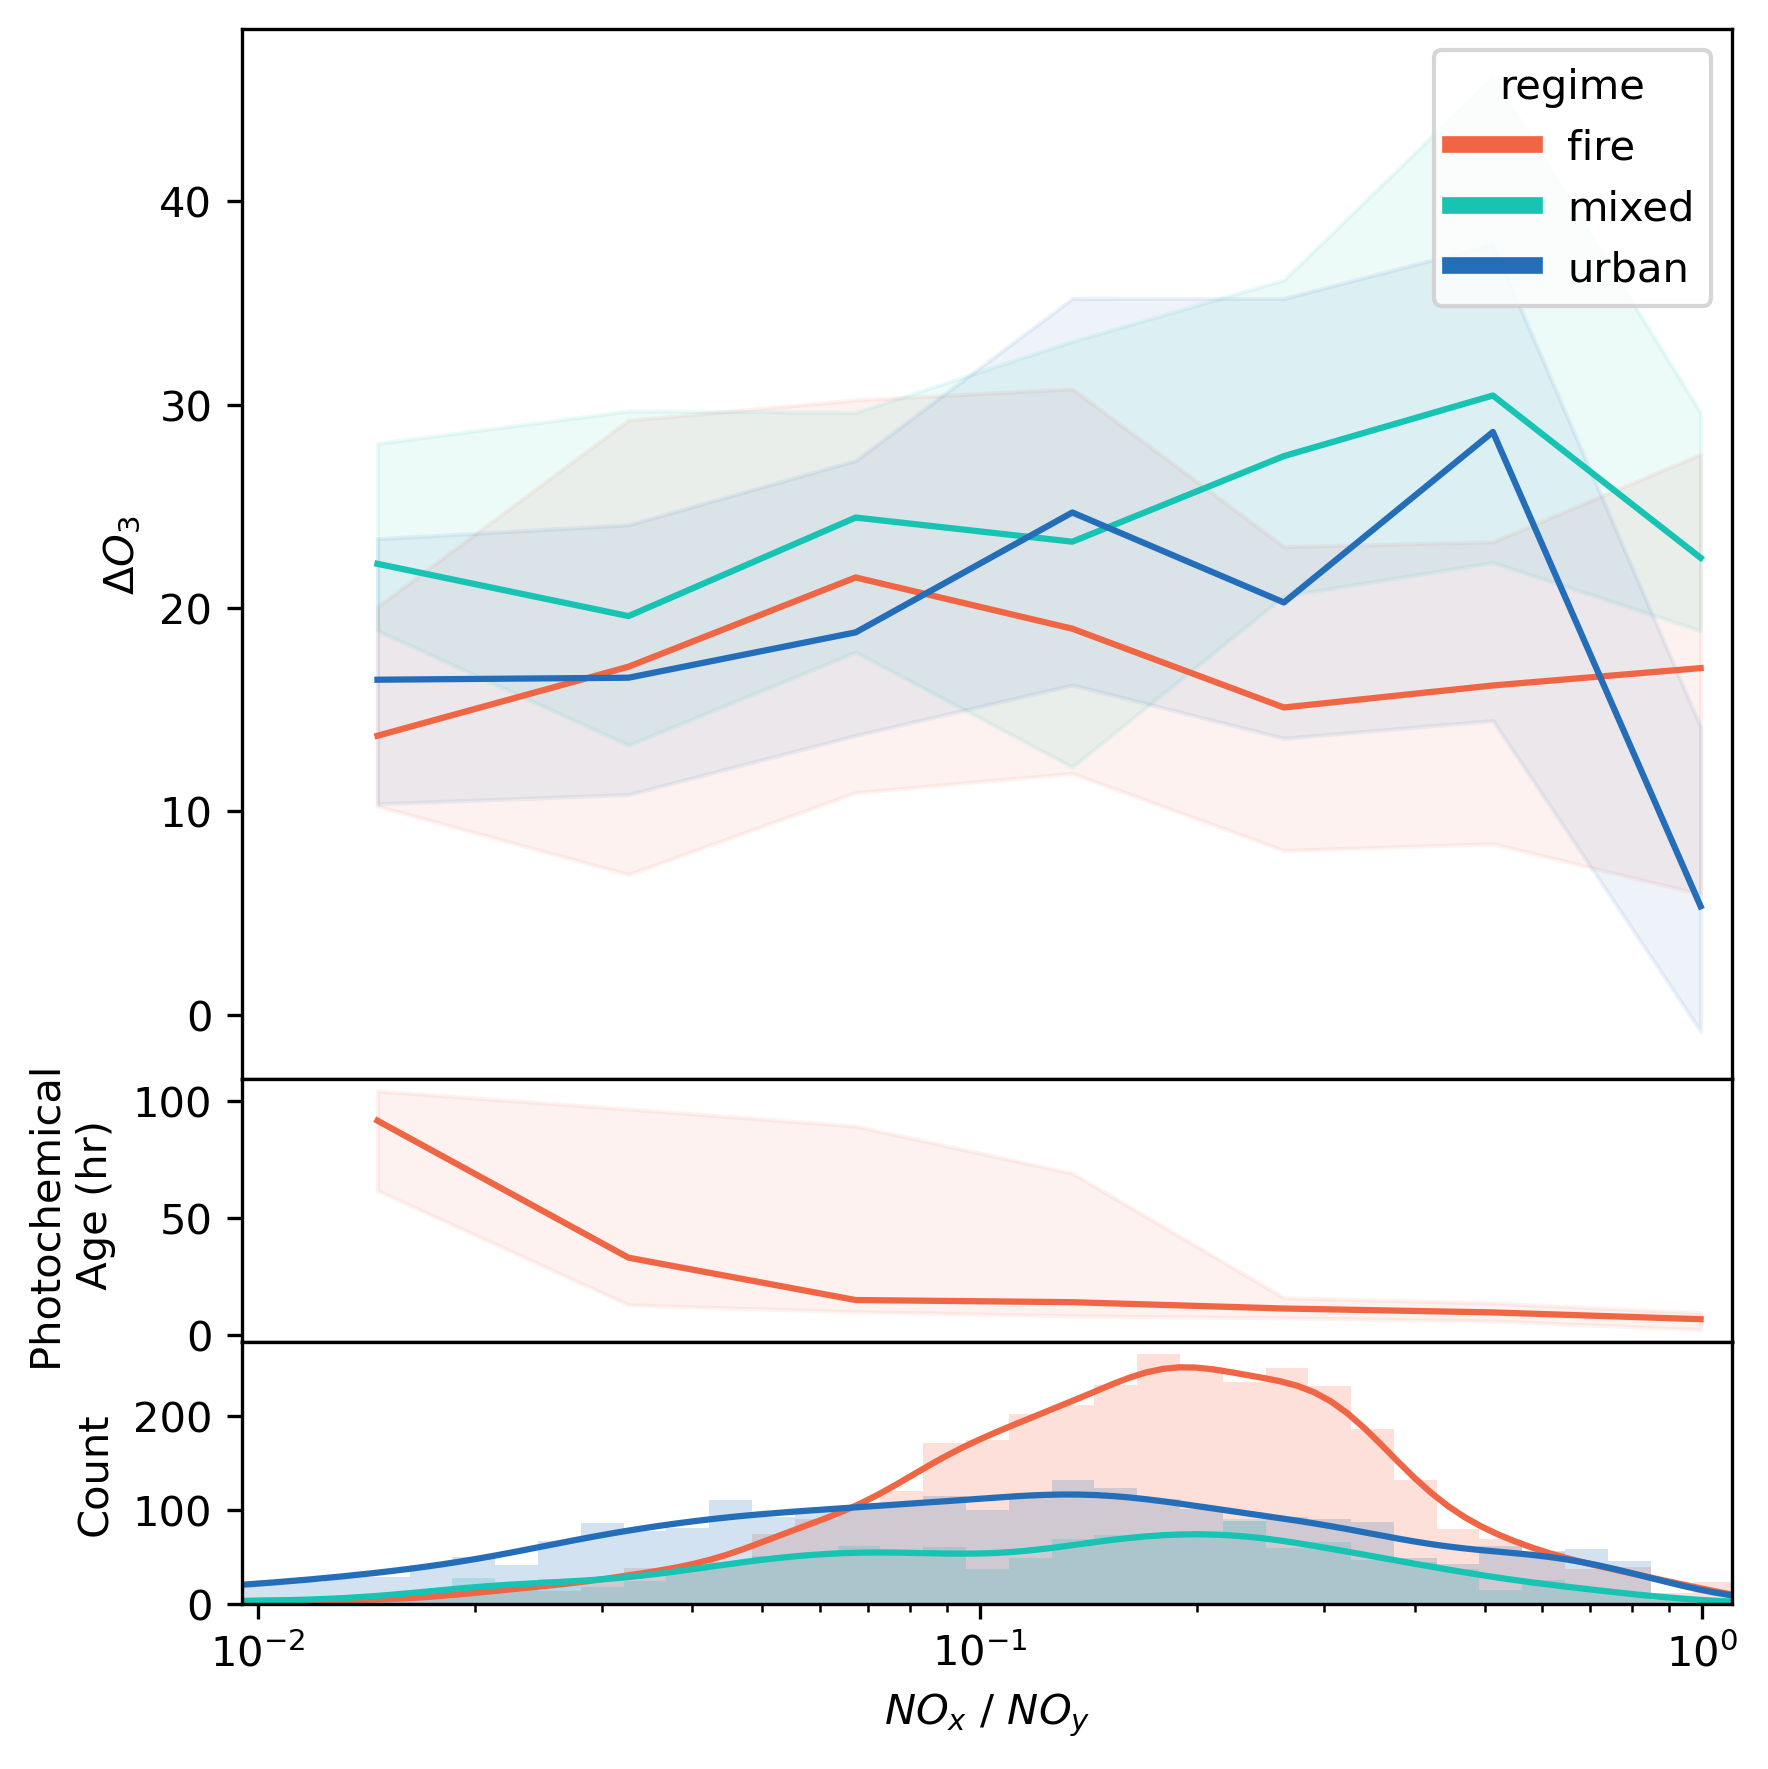

In [16]:
fig, axs = plt.subplots(3,1, sharex=True, gridspec_kw={'height_ratios':[8,2,2], 'hspace':0}, figsize=(6,6), dpi=300, )

tmp = df[(df['regime']=='fire')]#&(df['O3/CO']>0)]

NOx_bins = np.logspace(-2,0,8)
# NOx_bins = np.linspace(0,100,11)
# NOx_bins = np.geomspace(10,10000,11)

bin_result = binned_statistic(tmp['NOx/NOy'], tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanmedian(y), bins=NOx_bins,)
tenth_result = binned_statistic(tmp['NOx/NOy'], tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanpercentile(y,25), bins=NOx_bins,)
ninetieth_result = binned_statistic(tmp['NOx/NOy'], tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanpercentile(y,75), bins=NOx_bins,)
count_result = binned_statistic(tmp['NOx/NOy'], tmp['O3_delta'].values/1e3, statistic='count', bins=NOx_bins,)
bin_edges = (bin_result.bin_edges)
bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2

# ax.scatter(tmp['NOx'], tmp['O3/CO'], color=color_dict['fire'], alpha=0.1)
p = axs[0].plot(bin_centers, bin_result.statistic, label='fire', color=color_dict['fire'])
axs[0].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=color_dict['fire'])
# for i,b in enumerate(bin_centers):
#     ax.text(b, 1, int(count_result.statistic[i]), color=color_dict['fire'])

tmp = df[(df['regime']=='fire')]#&(df['O3/CO']>0)]

bin_result = binned_statistic(tmp['NOx/NOy'], tmp['age'].values, statistic=lambda y: np.nanmedian(y), bins=NOx_bins,)
tenth_result = binned_statistic(tmp['NOx/NOy'], tmp['age'].values, statistic=lambda y:np.nanpercentile(y,25), bins=NOx_bins,)
ninetieth_result = binned_statistic(tmp['NOx/NOy'], tmp['age'].values, statistic=lambda y:np.nanpercentile(y,75), bins=NOx_bins,)
count_result = binned_statistic(tmp['NOx/NOy'], tmp['age'].values, statistic='count', bins=NOx_bins,)
bin_edges = (bin_result.bin_edges)
bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2

# ax.scatter(tmp['NOx'], tmp['O3/CO'], color=color_dict['heavy_mixed'], alpha=0.1)
p = axs[1].plot(bin_centers, bin_result.statistic, label='fire', color=color_dict['fire'])
axs[1].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=color_dict['fire'])


tmp = df[(df['regime']=='heavy_mixed')]#&(df['O3/CO']>0)]

bin_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic=lambda y: np.nanmedian(y), bins=NOx_bins,)
tenth_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanpercentile(y,25), bins=NOx_bins,)
ninetieth_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanpercentile(y,75), bins=NOx_bins,)
count_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic='count', bins=NOx_bins,)
bin_edges = (bin_result.bin_edges)
bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2

# ax.scatter(tmp['NOx'], tmp['O3/CO'], color=color_dict['heavy_mixed'], alpha=0.1)
p = axs[0].plot(bin_centers, bin_result.statistic, label='mixed', color=color_dict['heavy_mixed'])
axs[0].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=color_dict['heavy_mixed'])
# for i,b in enumerate(bin_centers):
#     ax.text(b, 0.9, int(count_result.statistic[i]), color=color_dict['heavy_mixed'])

tmp = df[(df['regime']=='urban')]#&(df['O3/CO']>0)]

bin_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic=lambda y: np.nanmedian(y), bins=NOx_bins,)
tenth_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanpercentile(y,25), bins=NOx_bins,)
ninetieth_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic=lambda y:np.nanpercentile(y,75), bins=NOx_bins,)
count_result = binned_statistic(tmp['NOx/NOy'].values, tmp['O3_delta'].values/1e3, statistic='count', bins=NOx_bins,)
bin_edges = (bin_result.bin_edges)
bin_centers = bin_result.bin_edges[1:] - (abs(bin_result.bin_edges[0]-bin_result.bin_edges[1]))/2

# ax.scatter(tmp['NOx'], tmp['O3/CO'], color=color_dict['urban'], alpha=0.1)
p = axs[0].plot(bin_centers, bin_result.statistic, label='urban', color=color_dict['urban'])
axs[0].fill_between(bin_centers, tenth_result.statistic, ninetieth_result.statistic, alpha=0.08, color=color_dict['urban'])
# for i,b in enumerate(bin_centers):
#     ax.text(b, 0.8, int(count_result.statistic[i]), color=color_dict['urban'])

# axs[0].set_ylabel(r'Count', size=15)
axs[0].set_ylabel(r'$\Delta O_3$',)
axs[1].set_ylabel('Photochemical \n Age (hr)',)

axs[0].set_xlim(9.5e-3,1.1)

# We change the fontsize of minor ticks label 
axs[0].tick_params(axis='both', which='major',)
axs[0].tick_params(axis='both', which='minor',)
axs[1].tick_params(axis='both', which='major',)
axs[1].tick_params(axis='both', which='minor',)

axs[0].set_xscale('log')

# axs[1].set_yscale('log')

l = axs[0].legend()
l.set_title('regime')
for i in range(3):
    l.legendHandles[i]._sizes = [20]
    l.legendHandles[i].set_alpha(1)
    l.legendHandles[i].set_linewidth(4.0)

axs[2].set_xlabel(r'$NO_x$ / $NO_y$',)
tmp = df[(df['regime']=='fire')|(df['regime']=='heavy_mixed')|(df['regime']=='urban')]
sns.histplot(data=tmp, x='NOx/NOy', hue='regime', palette=color_dict, ax=axs[2], alpha=0.2, edgecolor=None, kde=True, legend=False)

fig.tight_layout()

#save figure as pdf
plt.savefig("../../figures/supfig_09.pdf", bbox_inches='tight', dpi=300)